# Final Project Report

* Class: DS 5100
* Student Name: Efrain Olivares
* Student Net ID: dpy8wq
* This URL: 

# Instructions

Follow the instructions in the Final Project isntructions notebook and put evidence of your work in this notebook.

Total points for each subsection under **Deliverables** and **Scenarios** are given in parentheses.

Breakdowns of points within subsections are specified within subsection instructions as bulleted lists.

This project is worth **50 points**.

# Deliverables

## The Monte Carlo Module (10)

- URL included, appropriately named (1).
- Includes all three specified classes (3).
- Includes at least all 12 specified methods (6; .5 each).

Put the URL to your GitHub repo here.

Repo URL:

Paste a copyy of your module here.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

In [1]:
# A code block with your classes.

## Unitest Module (2)

Paste a copy of your test module below.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

- All methods have at least one test method (1).
- Each method employs one of Unittest's Assert methods (1).

In [2]:
# A code block with your test code.

## Unittest Results (3)

Put a copy of the results of running your tests from the command line here.

Again, paste as text using triple backticks.

- All 12 specified methods return OK (3; .25 each).

## Import (1)

Import your module here. This import should refer to the code in your package directory.

- Module successuflly imported (1).

In [3]:
# e.g. import montecarlo.montecarlo 

## Help Docs (4)

Show your docstring documentation by applying `help()` to your imported module.

- All methods have a docstring (3; .25 each).
- All classes have a docstring (1; .33 each).

In [4]:
# help(montecarlo)

## `README.md` File (3)

Provide link to the README.md file of your project's repo.

- Metadata section or info present (1).
- Synopsis section showing how each class is called (1). (All must be included.)
- API section listing all classes and methods (1). (All must be included.)

URL:

## Successful installation (2)

Put a screenshot or paste a copy of a terminal session where you successfully install your module with pip.

If pasting text, use a preformatted text block to show the results.

- Installed with `pip` (1).
- Successfully installed message appears (1).

# Scenarios

Use code blocks to perform the tasks for each scenario.

Be sure the outputs are visible before submitting.

## Scenario 1: A 2-headed Coin (9)

Task 1. Create a fair coin (with faces $H$ and $T$) and one unfair coin in which one of the faces has a weight of $5$ and the others $1$.

- Fair coin created (1).
- Unfair coin created with weight as specified (1).

In [5]:
from montecarlo.montecarlo import Die, Game, Analyzer
import numpy as np

In [6]:
fair_coin = Die(np.array(['H','T'], dtype='object'))
unfair_coin = Die(np.array(['H','T'], dtype='object'))
unfair_coin.update_weight('T', 5)

Task 2. Play a game of $1000$ flips with two fair dice.

- Play method called correclty and without error (1).

In [7]:
game_ff = Game([fair_coin, fair_coin])
game_ff.play(1000)

,0,1
0,T,T
1,H,H
2,T,T
3,H,H
4,T,T
...,...,...
995,T,H
996,T,T
997,H,T
998,H,T


Task 3. Play another game (using a new Game object) of $1000$ flips, this time using two unfair dice and one fair die. For the second unfair die, you can use the same die object twice in the list of dice you pass to the Game object.

- New game object created (1).
- Play method called correclty and without error (1).

In [8]:
game_uuf = Game([unfair_coin, unfair_coin, fair_coin])
game_uuf.play(1000)

,0,1,2
0,T,T,H
1,H,H,T
2,T,T,H
3,H,H,H
4,T,H,H
...,...,...,...
995,H,H,T
996,T,T,T
997,T,H,H
998,H,T,T


Task 4. For each game, use an Analyzer object to determine the raw frequency of jackpots — i.e. getting either all $H$s or all $T$s.

- Analyzer objecs instantiated for both games (1).
- Raw frequencies reported for both (1).

In [9]:
analyze_ff = Analyzer(game_ff)
f_ff = analyze_ff.jackpot()
print(f"Frequency of fair coin jackpots is {f_ff} per 1000")
analyze_uuf = Analyzer(game_uuf)
f_uuf = analyze_uuf.jackpot()
print(f"Frequency of 2 unfair plus 1 fair coin jackpots is {f_uuf} per 1000")

Frequency of fair coin jackpots is 473 per 1000
Frequency of 2 unfair plus 1 fair coin jackpots is 249 per 1000


Task 5. For each analyzer, compute relative frequency as the number of jackpots over the total number of rolls.

- Both relative frequencies computed (1).

In [10]:
rel_f_ff = f_ff/1000
rel_f_uuf = f_uuf/1000
print(f"Relative frequencies of fair and unfair set {rel_f_ff}:{rel_f_uuf}")

Relative frequencies of fair and unfair set 0.473:0.249


Task 6. Show your results, comparing the two relative frequencies, in a simple bar chart.

- Bar chart plotted and correct (1).

<Axes: xlabel='game'>

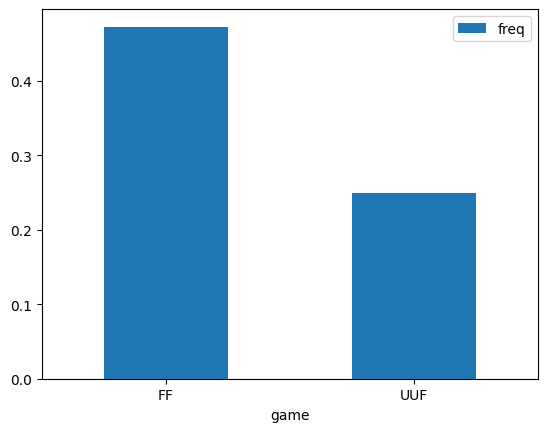

In [11]:
import pandas as pd
df = pd.DataFrame({'game':['FF', 'UUF'], 'freq':[rel_f_ff, rel_f_uuf]})
df.plot.bar(x='game', y='freq', rot=0)

## Scenario 2: A 6-sided Die (9)

Task 1. Create three dice, each with six sides having the faces 1 through 6.

- Three die objects created (1).

In [12]:
dice1 = Die(np.array(['1','2','3','4','5','6'], dtype='object'))
dice2 = Die(np.array(['1','2','3','4','5','6'], dtype='object'))
dice3 = Die(np.array(['1','2','3','4','5','6'], dtype='object'))

Task 2. Convert one of the dice to an unfair one by weighting the face $6$ five times more than the other weights (i.e. it has weight of 5 and the others a weight of 1 each).

- Unfair die created with proper call to weight change method (1).

In [13]:
dice1.update_weight('6', 5)

Task 3. Convert another of the dice to be unfair by weighting the face $1$ five times more than the others.

- Unfair die created with proper call to weight change method (1).

In [14]:
dice2.update_weight('1', 5)

Task 4. Play a game of $10000$ rolls with $5$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [15]:
game3 = Game([dice1, dice2, dice3])
game3.play(10000)

,0,1,2
0,6,4,2
1,4,6,5
2,3,5,5
3,3,4,4
4,2,4,2
...,...,...,...
9995,5,6,5
9996,1,3,5
9997,2,6,3
9998,1,5,1


Task 5. Play another game of $10000$ rolls, this time with $2$ unfair dice, one as defined in steps #2 and #3 respectively, and $3$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [16]:
dice4 = Die(np.array(['1','2','3','4','5','6'], dtype='object'))
dice5 = Die(np.array(['1','2','3','4','5','6'], dtype='object'))
game5 = Game([dice1, dice2, dice3, dice4, dice5])
game5.play(10000)

,0,1,2,3,4
0,3,1,4,5,4
1,4,2,2,5,4
2,6,3,3,3,6
3,2,3,1,5,2
4,5,3,1,2,5
...,...,...,...,...,...
9995,4,3,2,2,5
9996,1,4,5,6,4
9997,4,2,3,1,2
9998,6,4,1,6,3


Task 6. For each game, use an Analyzer object to determine the relative frequency of jackpots and show your results, comparing the two relative frequencies, in a simple bar chart.

- Jackpot methods called (1).
- Graph produced (1).

<Axes: xlabel='game'>

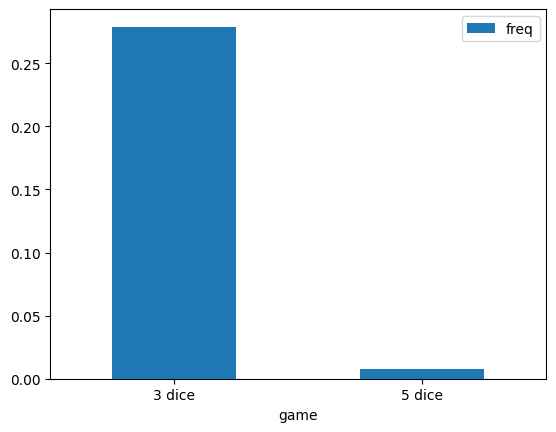

In [17]:
analyze_game3 = Analyzer(game3)
analyze_game5 = Analyzer(game5)
rel_f_game3 = analyze_game3.jackpot()/1000
rel_f_game5 = analyze_game5.jackpot()/1000
df = pd.DataFrame({'game':['3 dice', '5 dice'], 'freq':[rel_f_game3, rel_f_game5]})
df.plot.bar(x='game', y='freq', rot=0)

## Scenario 3: Letters of the Alphabet (7)

Task 1. Create a "die" of letters from $A$ to $Z$ with weights based on their frequency of usage as found in the data file `english_letters.txt`. Use the frequencies (i.e. raw counts) as weights.

- Die correctly instantiated with source file data (1).
- Weights properly applied using weight setting method (1).

In [18]:
letters = []
weights = []

# Load the file into letters and weights lists
for letter_line in open('data/english_letters.txt', 'r').readlines():
    letters.append(letter_line.split()[0].strip())
    weights.append(int(letter_line.split()[1].strip()))

# Create the dice
dice = [Die(np.array(letters, dtype='object'))]*4

# Update weights on the dice
for die in dice:
    [die.update_weight(let, wei) for let, wei in zip(letters, weights)]

Task 2. Play a game involving $4$ of these dice with $1000$ rolls.

- Game play method properly called (1).

In [19]:
scrabble_game = Game(dice)
scrabble_game.play(1000)

,0,1,2,3
0,Y,R,E,F
1,D,S,W,B
2,W,P,A,P
3,U,F,F,R
4,H,J,B,Y
...,...,...,...,...
995,K,M,P,S
996,E,Q,U,M
997,X,I,D,V
998,H,J,G,E


Task 3. Determine how many permutations in your results are actual English words, based on the vocabulary found in `scrabble_words.txt`.

- Use permutation method (1).
- Get count as difference between permutations and vocabulary (1).

In [24]:
ana_scrabble = Analyzer(scrabble_game)
df_words = ana_scrabble.permutation_count()
scrabble_words = {word.strip() for word in open('data/scrabble_words.txt', 'r').readlines()}
set_words = set(df_words.index.to_list())
scrabble_words.intersection(set_words)

{'BURD',
 'DOOM',
 'JAGA',
 'LOBI',
 'PROD',
 'RONE',
 'SORI',
 'TIRE',
 'TOLT',
 'TUBS'}

Task 4. Repeat steps #2 and #3, this time with $5$ dice. How many actual words does this produce? Which produces more?

- Successfully repreats steps (1).
- Identifies parameter with most found words (1).

In [26]:
# Create the dice
dice = [Die(np.array(letters, dtype='object'))]*5

# Update weights on the dice
for die in dice:
    [die.update_weight(let, wei) for let, wei in zip(letters, weights)]

# Step 2
scrabble_game = Game(dice)
scrabble_game.play(1000)

# Step 3
ana_scrabble = Analyzer(scrabble_game)
df_words = ana_scrabble.permutation_count()
set_words = set(df_words.index.to_list())
scrabble_words.intersection(set_words)

{'MOPSY', 'OMENS'}

# Conclusion
Running with 5 dice drastically reduces the number of matched words from ROUGHLY 10, to 1.  A 10:1 ratio between using 4:5 letters